# Energy Minimization Assignment, PharmSci 175/275
##### By David Mobley (UCI), Jan. 2018

##### Adapted with permission from an assignment by M. Scott Shell (UCSB)

## Overview
In this assignment, you will begin with a provided template and several functions, as well as a Fortran library, and add additional code to perform a conjugate-gradient minimization. That is, you will write a conjugate-gradient minimizer. You will then apply this minimize to generate Lennard-Jones clusters with varying numbers of particles, and look at how the energy varies as a function of cluster size.  

The Jupyter notebook for this assignment is laid out with action items YOU need to take labeled as Step 1-7. These are interspersed with background information on the problem, some examples, and a sandbox section to tinker with some of the functions. So read on, and watch for the sections which require your action.

## What are Lennard-Jones clusters?

Clusters are small, stable packings of (often spherical) particles. These particles could be colloidal particles, nanoparticles, etc. There has been considerable work spent studying these clusters over the years, from atomic sizes up to colloidal particles in the nanometer to micrometers scale. Cluster analysis is important to understanding a range of phenomena, including structures of solids, aggregation and precipitation of particles, the structure of nanomaterials, self-assembly behavior of synthetic and biomolecular systems, and diffusion in dense liquids.

A cluster can be characterized by the number and type of particles and the energetic interactions between them. Here, we will examine Lennard-Jones (LJ) clusters, which are clusters of simple attractive spherical particles with interactions modeled by the Lennard-Jones interaction. 

For LJ clusters, there are cluster sizes of unusual stability. These are called magic number clusters and correspond to cluster sizes where the packing of atoms is particularly efficient, leading to very favorable energies and hence exceptional stability. The most stable such clusters are built from an icosahedral arrangement of particles, and the first few such **magic numbers** for cluster sizes of icosahedral geometries are 13, 19, 38, 55, and 75. 

These clusters are still interesting from a basic physical chemistry point of view, but our interest here is mainly in (a) energy minimization algorithms, and (b) learning how to do non-trivial numerics in Python.

## Here, we will energy minimize Lennard-Jones clusters of different sizes

Here, we will examine different numbers of particles and attempt to find the minimum energy cluster for each number of particles. Our energy model will use the LJ potential in its dimensionless form (meaning that we have changed units so that all of the constants are hidden in the units). We denote this by putting a star on the potential:

\begin{equation}
U^* = \sum \limits_{i<j} 4(r_{ij}^{-12} - r_{ij}^{-6})
\end{equation}

We will start with a random initial configuration of particles, and try to use an energy minimization algorithm to find the most stable configuration of particles. But when there are more than just a few particles, there will be more than one local minimum, so there is no guarantee the energy minimizer will find the global minimum. In such cases, we will need to minimize from random initial configurations many times in order to ensure we locate the global minimum.
There is also the possibility of forming multiple separate clusters separated by a significant difference. This is not unlikely, since the LJ interaction is only very weakly attractive at large distances. So, to ensure we form single clusters, we will use a weak biasing potential to pull all of the particles towards the origin, biasing the system towards forming a single cluster. Otherwise, the LJ potential will tend to be too weak to pull together very distant particles in these tests. We will use a harmonic biasing potential, so that the total potential energy (“force field”) is:

\begin{equation}
U^* = \sum\limits_i \alpha |\mathbf{r}_i|^2 + \sum \limits_{i<j} 4(r_{ij}^{-12} - r_{ij}^{-6})
\end{equation}

Here we will use $\alpha = 0.0001 N^{-2/3}$ where $N$ is the number of particles; this will be a very small number. This particular form is selected so that the energy due to this term for a cluster of $N$ particles is, on average, constant regardless of $N$.

## Additional details
For this assignment, your job is to perform a conjugate-gradient minimization of Lennard-Jones particles which are initially randomly distributed in space. I am providing several items for you:
* A Fortran library (emlib) which you can use within Python to calculate energies and forces
* A Python library (pos_to_pdb.py) which you can use to output structures to your disk to visualize motion of your particles (for example with PyMol) if you so desire
* A template for your assignment (below) in iPython notebook format; this also will be posted on the class website in plain Python format in case my experiment with iPython notebooks fails here. 
 * This template contains some code which will get you started, including code for a line search minimization. 
 * It also contains places for you to write the functions (outlined below) you need to write to complete the assignment.
* Here we will be using position and force arrays to represent positions/forces on all of the atoms in the system. Make sure you are [comfortable with that notation](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/energy_minimization/energy_minimization.ipynb) before beginning.
 
## A quick (but important) note on Notebook usage:
iPython notebooks such as this one often contain a variety of cells containing code. These are normally intended to be run, which you can when you have an individual cell selected, by hitting the button at the top with a 'play' symbol, or by typing shift-enter. If you do NOT do so on each of the cells defining variables/functions which will be used here, then you will encounter an error about undefined variables when you run the later cells. 
 
## Your step 1 for the assignment: Start by doing some file bookkeeping:
 * Find `emlib.f90` and optional utility `pos_to_pdb.py` in this directory.
 * In the command prompt navigate to that folder and type 'f2py -c -m emlib emlib.f90' which should compile the fortran library for use within python (For more on F2Py, refer to the [f2py documentation](https://docs.scipy.org/doc/numpy-dev/f2py/)). In OS X, this may require you to install the (free) XCode developer tools (available from the Mac App store) and the command-line developer tools first (the latter via `xcode-select --install`). In Linux it should just work. Windows would be a hurdle.
 * In your command prompt, start theis Jupyter notebook (in OSX this would be something like 'Jupyter notebook 272EnergyMinimization'), which should open it in your web browser; you're running it already unless you are looking at the HTML version of this file.
 
Template Python code for the assignment is provided below. I suggest making a new notebook which is a copy of this one (perhaps containing your name in the filename) and working from there. 
 
 
 ## Next, we prep Python for the work:
 
 First we import the numpy numerical library we're going to need, as well as the compiled Fortran library emlib

In [ ]:
# Run cell if using collab

# Import condacolab python library and install condacolab (~5 minutes). 
# Rerun cell after crashing
#!pip install --target=$nb_path -q condacolab
#import condacolab
#condacolab.install()

#check condacolab to ensure that it works
#condacolab.check()

#other installs
#!conda install -c conda-forge nb_conda nglview py3dmol mdtraj --yes
!pip install emlib 
#!conda install -c anaconda scipy numpy --yes
#!conda install -c openeye openeye-toolkits --yes

# Mount google drive to Colab Notebooks to access files
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# Move into directory 
%cd /content/drive/MyDrive/drug-computing/uci-pharmsci/assignments/energy_minimization

In [2]:
import numpy as np
import emlib
from pos_to_pdb import * 
#This would allow you to export coordinates if you want, later

## Important technical note: Unit masses, etc.

Note that all of the following code will assume unit atomic masses, such that forces and accelerations are equal -- that is, instead of $F=ma$ we write $F=a$ assuming that $m=1$. We also drop most constants. This is a relatively common trick in physics when you are interested only in seeing how the basic equations work, and not in quantitative comparison with experimental numbers. It can be called using "dimensionless units". 

## Then we define the LineSearch function:

Here is the `LineSearch` function which is provided for you. Read the prototype (definition) and documentation to understand what it needs and what it will do (note that you do NOT need to read all the code):

In [3]:
def LineSearch(Pos, Dir, dx, EFracTol, Accel = 1.5, MaxInc = 10.,
               MaxIter = 10000):
    """Performs a line search along direction Dir.
    Input:
       Pos: starting positions, (N,3) array
       Dir: (N,3) array of gradient direction
       dx: initial step amount, a float
       EFracTol: fractional energy tolerance
       Accel: acceleration factor
       MaxInc: the maximum increase in energy for bracketing
       MaxIter: maximum number of iteration steps
Output:
       PEnergy: value of potential energy at minimum along Dir
       PosMin: minimum energy (N,3) position array along Dir
"""
    #start the iteration counter
    Iter = 0

    #find the normalized direction
    NormDir = Dir / np.sqrt(np.sum(Dir * Dir))

    #take the first two steps and compute energies
    Dists = [0., dx]
    PEs = [emlib.calcenergy(Pos + NormDir * x) for x in Dists]

    #if the second point is not downhill in energy, back
    #off and take a shorter step until we find one
    while PEs[1] > PEs[0]:
        Iter += 1
        dx = dx * 0.5
        Dists[1] = dx
        PEs[1] = emlib.calcenergy(Pos + NormDir * dx)

    #find a third point
    Dists.append( 2. * dx )
    PEs.append( emlib.calcenergy(Pos + NormDir * 2. * dx) )

    #keep stepping forward until the third point is higher
    #in energy; then we have bracketed a minimum
    while PEs[2] < PEs[1]:
        Iter += 1

        #find a fourth point and evaluate energy
        Dists.append( Dists[-1] + dx )
        PEs.append( emlib.calcenergy(Pos + NormDir * Dists[-1]) )

        #check if we increased too much in energy; if so, back off
        if (PEs[3] - PEs[0]) > MaxInc * (PEs[0] - PEs[2]):
            PEs = PEs[:3]
            Dists = Dists[:3]
            dx = dx * 0.5
        else:
            #shift all of the points over
            PEs = PEs[-3:]
            Dists = Dists[-3:]
            dx = dx * Accel    
                
    #we've bracketed a minimum; now we want to find it to high
    #accuracy
    OldPE3 = 1.e300
    while True:
        Iter += 1
        if Iter > MaxIter:
            print("Warning: maximum number of iterations reached in line search.")
            break

        #store distances for ease of code-reading
        d0, d1, d2 = Dists
        PE0, PE1, PE2 = PEs

        #use a parobolic approximation to estimate the location
        #of the minimum
        d10 = d0 - d1
        d12 = d2 - d1
        Num = d12*d12*(PE0-PE1) - d10*d10*(PE2-PE1)
        Dem = d12*(PE0-PE1) - d10*(PE2-PE1)
        if Dem == 0:
            #parabolic extrapolation won't work; set new dist = 0
            d3 = 0
        else:
            #location of parabolic minimum
            d3 = d1 + 0.5 * Num / Dem

        #compute the new potential energy
        PE3 = emlib.calcenergy(Pos + NormDir * d3)

        #sometimes the parabolic approximation can fail;
        #check if d3 is out of range < d0 or > d2 or the new energy is higher
        if d3 < d0 or d3 > d2 or PE3 > PE0 or PE3 > PE1 or PE3 > PE2:
            #instead, just compute the new distance by bisecting two
            #of the existing points along the line search
            if abs(d2 - d1) > abs(d0 - d1):
                d3 = 0.5 * (d2 + d1)
            else:
                d3 = 0.5 * (d0 + d1)
            PE3 = emlib.calcenergy(Pos + NormDir * d3)

        #decide which three points to keep; we want to keep
        #the three that are closest to the minimum
        if d3 < d1:
            if PE3 < PE1:
                #get rid of point 2
                Dists, PEs = [d0, d3, d1], [PE0, PE3, PE1]
            else:
                #get rid of point 0
                Dists, PEs = [d3, d1, d2], [PE3, PE1, PE2]
        else:
            if PE3 < PE1:
                #get rid of point 0
                Dists, PEs = [d1, d3, d2], [PE1, PE3, PE2]
            else:
                #get rid of point 2
                Dists, PEs = [d0, d1, d3], [PE0, PE1, PE3]

        #check how much we've changed
        if abs(OldPE3 - PE3) < EFracTol * abs(PE3):
            #the fractional change is less than the tolerance,
            #so we are done and can exit the loop
            break
        OldPE3 = PE3

    #return the position array at the minimum (point 1)
    PosMin = Pos + NormDir * Dists[1]
    PEMin = PEs[1]

    return PEMin, PosMin

## Step 2: Write a function to assign random initial positions to your atoms

We need a function that can randomly place N atoms in a box with sides of length L. Write a function based on a tool from the numpy 'random' module to do this. Some hints are in order:

* NumPy contains a ‘random’ module which is good for obtaining random numbers and/or arrays. For example, if you have imported numpy as np, then np.random.random(shape) returns a random array with the specified shape (i.e. ‘np.random.random(3)’ would be a 3x1 array) with elements randomly selected between 0 to 1. Try this out: 

In [4]:
a = np.random.random(3)
print("a=\n",a)
b = np.random.random((2,3))
print("b=\n",b)

a=
 [0.02856741 0.05772524 0.93436708]
b=
 [[0.97914562 0.54823413 0.37962706]
 [0.27729272 0.25168129 0.17951113]]


* Note that in your function, you want the numbers to run from 0 to L. You might try out what happens if you multiply 'a' and 'b' in the code above by some number.

Now, write your function. I've written the doc string and some comments for you, but you have to fill in its inner workings:

In [5]:
def InitPositions(N, L):
    """Returns an array of initial positions of each atom,
placed randomly within a box of dimensions L.
Input:
    N: number of atoms
    L: box width
Output:
    Pos: (N,3) array of positions
"""
    #### WRITE YOUR CODE HERE ####
    ## In my code, I can accomplish this function in 1 line 
    ## using a numpy function.
    ## Yours can be longer if you want. It's more important that it be right than that it be short.
    
    return Pos

## Step 3: Write the Conjugate Gradient function described below

Fill in code for the ConjugateGradient function below based on the discussion in class and below, supplemented by your reading of Leach's book (and other online sources if needed). Some additional guidance and hints are warranted first.

### Hints for ConjugateGradient:
* As discussed/demonstrated above, a LineSearch function is already provided for you here
* You will need to remember that our force and position arrays give the force/position of all of the atoms in the system (x, y, and z components) as [introduced previously](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/energy_minimization/energy_minimization.ipynb). 
* Keep careful track of which quantities you expect to be vectors/arrays versus scalars. You may wish to check that quantities are what you expect they are.
* You are going to want to keep doing line searches until the energy stops changing. Write a loop to do this, and store your evaluated energies as you go.
* A fortran library, `emlib`, is provided for you to calculate energies and forces. You should be able to ask for 'help(emlib)' for info on usage. You can also look directly at the Fortran code if you would like, though this may be less helpful.
* You can get the potential energy and forces using the provided library using functions from emlib. For example, if `Pos` is an array of positions: 

   `PEnergy, Forces = emlib.calcenergyforces(Pos)`
   
   `Forces = emlib.calcforces( Pos )`
* Conjugate gradient does not specify an initial direction. Your initial search should be in the direction of the force. 
* After the initial line search, subsequent line search directions $i$ should be found using this expression for $v_i$, the direction matrix:

   \begin{equation}
   \mathbf{v}_i^N = \mathbf{f}_i^N + \gamma_i \mathbf{v}_{i-1}^N
   \end{equation}
   
   where
   
   \begin{equation}
   \gamma_i = \frac{ (\mathbf{f}_i^N-\mathbf{f}_{i-1}^N) \mathbf{f}_i^N}{\mathbf{f}_{i-1}^N \mathbf{f}_{i-1}^N}
   \end{equation}
   
   Note that here, $\mathbf{f}_i^N$ denotes the force on the particles at step $i$ (and hence it has 3N dimensions - $x$, $y$, and $z$ for each particle) and $\mathbf{f}_{i-1}^N$ is the force at the last ($i-1$) step, [as discussed previously](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/energy_minimization/energy_minimization.ipynb). Note that the forces are a collection of vectors, one vector for the force on each particle. $\gamma_i$ should be just a number (scalar). Hint: Note that if you have a force array consisting of a set of vectors, the product you want inside the equation for $\gamma_i$ should be an element-by-element multiplication, not a dot or inner product.  **Be sure to see the helpful tips about how to calculate this which were given in the energy minimization lecture**!
   
* You want to end up at the point, in your code, where you can obtain the new direction by calculating something like `Dir = newForces + gamma * Dir`
* Continue successive line searches in your CG minimization until the fractional change in energy on subsequent searches is less than the tolerance. That is, you'll set it up to use an `EFracTolCG` variable and continue until this criteria is met (where $U_i$ is the potential energy at the present step): 
\begin{equation}
\left|U_i-U_{i-1}\right| < EFracTolCG \times \left| U_i\right|
\end{equation}

* To debug your code, you will probably want to initially use `print` statements in the minimization routine to monitor the energy as a function of step to make sure it's doing the right thing!



### Now actually write ConjugateGradient:

In [6]:
def ConjugateGradient(Pos, dx, EFracTolLS, EFracTolCG):
    """Performs a conjugate gradient search.
Input:
    Pos: starting positions, (N,3) array
    dx: initial step amount
    EFracTolLS: fractional energy tolerance for line search
    EFracTolCG: fractional energy tolerance for conjugate gradient
Output:
    PEnergy: value of potential energy at minimum
    Pos: minimum energy (N,3) position array
"""
    #### WRITE YOUR CODE HERE ####
    ## In my code, I can accomplish this function in 10 lines ###
    
    #A return statement you may/will use to finish things off    
    return PEnergy, Pos

## Step 4: Energy minimize a variety of clusters, storing energies

Write code to use the functions you wrote above, plus the emlib module, to energy minimize clusters of various sizes. Loop over clusters from size N=2 to (and including) N=25. For each particle number, do the following:
* Perform K (to be specified below in the section on graphing) minimizations, each starting from a different random configuration of particles 
* Store the K energies to a list 
* Display the minimum, average, and standard deviation of the minimized energies for the trials. Note standard deviations can be calculated with the numpy.std function (`np.std()`)
* After doing this, you'll be tasked with making some plots. 

Use the following settings:
* `dx = 0.001`
* `EFracTolCG = 1.0e-10`
* `EFracTolLS = 1.0e-8`
* And place the particles with L chosen such that the average number density of particles ($N/V$, where $V=L^3$) is $0.001$. That is, for every $N$, solve for $L$ such that $N/L^3 = 0.001$. 

These are relatively typical settings for this kind of a system. 

**I suggest you do this first for just one N and K to make sure it works**. Then set up a loop over N and perhaps (if you like) a loop over K as well.  Reserve the large K values until you are absolutely certain it’s working. Note that if the computational time becomes prohibitive (i.e. if it runs more than overnight, or your computer is having difficulties handling the lode) we can migrate your simulations to GreenPlanet. 

You can easily add visualization of a trajectory by adding, within your ConjugateGradient function’s central loop, a call to the PosToPDB function of the pos_to_pdb module. Assuming you’ve done ‘from pos_to_pdb import *’ you’d add something like: 

`PosToPDB( Pos, L, ‘mytrajectory.pdb’)`

within the loop inside your ConjugateGradient minimizer. This will write out each step of the minimization as a separate frame in a pdb file, which you can download with scp and view in PyMol to see exactly what’s going on. 
Note that visualization (really, the file I/O and coordinate conversions) will slow things considerably, so I suggest you only do this in one specific case to check out what’s going on, or to troubleshoot if things don't appear to be working. It should also be possible to add interactive visualization via `nglview` here, though I've not done that for you.

* Hint: **You MAY want to use Python's pickle module to save out your data at the end of your calculations, since the next step involves plotting your data and you may want to easily be able to read it back in**. At the very least - whether you save it to disk or not - you'll want to store it (specifically, the minimum and average energies at each N) to variables for later reuse. If you had the variable `energies` containing all of the energies obtained at K = 10000 you might dump this using:

In [7]:
%ls

emlib.f90                             Leary_table.png
energies.pickle                       pos_to_pdb.py
energy_minimization_assignment.html   __pycache__/
energy_minimization_assignment.ipynb  README.md


In [8]:
import pickle
file = open('energies.pickle', "w")
pickle.dump( energies, file) 
file.close()
#To load again, use:
#file = open("energies.pickle", "r") 
#energies = pickle.load(file)
#file.close()

NameError: ignored

### Write your code here:


In [ ]:
#Your energy minimization code here
#This will be the longest code you write in this assignment

## Step 5: Graph your findings

Plot the minimum and average energies as a function of N for each of K=100, 1000, and 10000. The last case may be fairly time consuming (i.e. several hours) and should be done without output of pdb files for visualization (since this can slow it down).

Use matplotlib/PyLab to make these plots.

**Hint: If your minimizations are proceeding extremely slowly, it may mean you have an error in calculation of gamma**, such that even K=100 or K=10 could take a very long time. Ensure you have implemented the equation for gamma correctly. Even with a correct gamma value, this will take considerable time for the larger N values.

In [ ]:
#Your code for this here

## Step 6: Compare with what's expected

Compare your results (your minimum energy at each N value) with the known global minimum energies, via a plot and by commenting on the results. These are from ( Leary, J. Global Optimization 11:35 (1997)). Add this curve to your graph. Why might your results be higher?


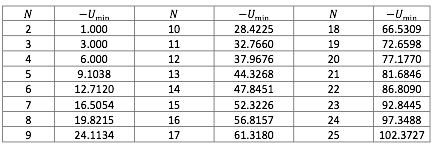

In [11]:
from IPython.display import Image

Image('Leary_table.png',width = 700)

In [ ]:
#Write code here to add these to your graph

## Step 7: Fit a curve to the data 

(**For undergraduates, this section is optional.**)

Based on macroscopic arguments, the energy of a cluster could scale with both surface area (via a surface tension) and volume (via an energy density for bulk) of the cluster. So we could model the minimum energy as depending on the cluster size in this way:
\begin{equation}
U_{min} \propto a + b N^{2/3} +cN
\end{equation}

Fit this equation to your data in the K=10000 case. You can do this using a least-squares fit, for example using fitting functions within SciPy (`optimize.leastsq`, for example, or similar functions in `scipy.stats`. A fairly dated tutorial is [here](http://www.tau.ac.il/~kineret/amit/scipy_tutorial) (sec 5.4), or see [stack overflow](https://stackoverflow.com/questions/19791581/how-to-use-leastsq-function-from-scipy-optimize-in-python-to-fit-both-a-straight).

**Once you perform the fit, plot the difference between the true minimum energy and the expected energy from this equation as a function of N. Can you identify the magic numbers from this curve?**

In [ ]:
#Your code here

## Step 8: Submit your results

Submit (via Canvas) your graphs, with axes and curves labeled. Also attach a copy of your Python code (this notebook or, if you prefer, a separate script). Specifically, you should be including:
* Your Python code
* A graph (or graphs) of minimum and average energies as a function of N for K=100, 1000, and 10000. (Note you can use savefig to save graphs). These can be included in this notebook, or saved separately.
* A graph comparing your results for the K=10000 case with the expected results from Leary, as a function of N, overlaid with a fitted curve using the equation above (Step 7); undergrads can omit the fit if desired as this is optional. Provide the parameters determined in your fit.
* Give brief discussion of why your results might be higher than those of Leary. Comment on the magic numbers (step 7).  

### Please give clear answers to questions given above, ideally in a box below or a separate report

Specifically, explain whether you can identify the magic numbers, how you can tell what they are, etc. If you are not certain whether your results are right, explain any reservations you have and why, discuss where you think you might have gone wrong, etc. Basically, be sure to answer all my questions AND give a very brief discussion of your results. The main ways to lose points on this assignment are to:
- not finish
- submit late
- not discuss your results
I tend to be generous with partial credit for people whose work is mostly correct/mostly complete.